In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


# Introduction
The rapid growth of e-commerce platforms like Amazon has generated vast amounts of user-generated content in the form of product reviews, which serve as valuable feedback for consumers and businesses alike. These reviews often express sentiments ranging from satisfaction to frustration, making them a rich source for sentiment analysis. This project focuses on analyzing a large-scale dataset of Amazon product reviews to classify them as positive or negative, leveraging machine learning techniques to uncover patterns in user sentiment. By exploring the textual content and structural features of reviews, the project aims to build a robust predictive model and derive actionable insights for understanding consumer behavior.

# Project description
The dataset used in this project is the Amazon Reviews dataset from Kaggle (https://www.kaggle.com/datasets/bittlingmayer/amazonreviews), comprising approximately 3.6 million training reviews. Each review consists of a text field (review) and a sentiment label (label), where 0 indicates a negative review and 1 indicates a positive review. The dataset is derived from Amazon product reviews and is preprocessed to facilitate binary sentiment classification.

The project involves the following key phases:

1. Data Loading and Preprocessing: Extracting the dataset from a zip file and loading it into a Pandas DataFrame, ensuring proper handling of text and labels.
2. Exploratory Data Analysis (EDA): Investigating the distribution of features, correlations, and data quality to inform feature engineering and modeling.
3. Feature Engineering: Deriving features such as review length, and TF-IDF vectors from the text to capture sentiment signals.
4. Modeling: Developing a Transformers machine learning model to classify reviews as positive or negative.
5. Evaluation and Insights: Assessing model performance and confirming the importance of key features to draw conclusions about consumer sentiment patterns.

Goal: The primary goal of this project is to develop an accurate sentiment classification model for Amazon product reviews, capable of distinguishing positive and negative sentiments with high performance.

In [3]:
import bz2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import datasets
from datasets import Dataset

2025-04-26 01:33:40.783471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745631221.036458      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745631221.103769      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import torch
import tensorflow as tf
import torch.nn as nn
import transformers
from transformers import AutoTokenizer, PreTrainedModel, PretrainedConfig, Trainer, TrainingArguments

In [5]:
# upgrading to latest version for evaluation strategy
# !pip install --upgrade transformers

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from scipy.special import softmax

In [7]:
# Path to file
file_path = '/kaggle/input/amazonreviews/train.ft.txt.bz2'

# Load entire dataset
data = []
with bz2.open(file_path, 'rt', encoding='utf-8') as file:
    for line in file:
        label, text = line.split(' ', 1)
        label = 1 if label == '__label__2' else 0
        data.append({'review': text.strip(), 'label': label})

# Create DataFrame
df = pd.DataFrame(data)
df1 = pd.DataFrame(data)
df.to_csv('/kaggle/working/amazon_reviews_full.csv', index=False)
print(df.head())
print(f"Total reviews: {len(df)}")
print(f"Positive reviews: {sum(df['label'] == 1)}")
print(f"Negative reviews: {sum(df['label'] == 0)}")

                                              review  label
0  Stuning even for the non-gamer: This sound tra...      1
1  The best soundtrack ever to anything.: I'm rea...      1
2  Amazing!: This soundtrack is my favorite music...      1
3  Excellent Soundtrack: I truly like this soundt...      1
4  Remember, Pull Your Jaw Off The Floor After He...      1
Total reviews: 3600000
Positive reviews: 1800000
Negative reviews: 1800000


The dataset has 3.6M records or 1.8M of positive & negative each & when we try using this with the transformers model, it took hours & still the model hasn't completed training. So reducing the datset to 500K of 250k of each positive & negative labels.

In [8]:
target_per_class = 250000
# Separate positive and negative reviews
positive_reviews = df[df['label'] == 1]
negative_reviews = df[df['label'] == 0]
# Sample equal number of positive and negative reviews
positive_sample = positive_reviews.sample(n=target_per_class, random_state=42)
negative_sample = negative_reviews.sample(n=target_per_class, random_state=42)
df = pd.concat([positive_sample, negative_sample], ignore_index=True)

print(df.head())
print(f"Total reviews: {len(df)}")
print(f"Positive reviews: {sum(df['label'] == 1)}")
print(f"Negative reviews: {sum(df['label'] == 0)}")

                                              review  label
0  Perfect Mantra: I've been looking for this man...      1
1  Quality: I'm just a little disapointed with th...      1
2  Exceptional murder-mystery writer scores big.:...      1
3  all the prodding questions you never wanted to...      1
4  Best Wok ever: I am so glad I bought this wok....      1
Total reviews: 500000
Positive reviews: 250000
Negative reviews: 250000


# EDA

Features Description :Amazon dataset has following features:
1. Label encoded as 1(positive) and 0 (negative)
2. Raw text of the reviews
3. Additional features like review length(number of words in review text), word count,sentiment score are to be created 

# EDA Visualizations for each feature
1. Review Lengths for both positive & negative reviews
2. Label (Sentiment)
3. Label vs. Review Length(coorelation between features)
4. Correlation Test: Use a statistical test to check if review length differs significantly between sentiments
5. Text Content Correlations:Since raw text isn’t numeric, we can derive features like word frequency or sentiment scores and check their correlation with the label.
6. Word Frequency Analysis


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   review      500000 non-null  object
 1   label       500000 non-null  int64 
 2   word_count  500000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 11.4+ MB
None

First 5 rows:
                                              review  label  word_count
0  Perfect Mantra: I've been looking for this man...      1          47
1  Quality: I'm just a little disapointed with th...      1          25
2  Exceptional murder-mystery writer scores big.:...      1          72
3  all the prodding questions you never wanted to...      1         115
4  Best Wok ever: I am so glad I bought this wok....      1          75


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


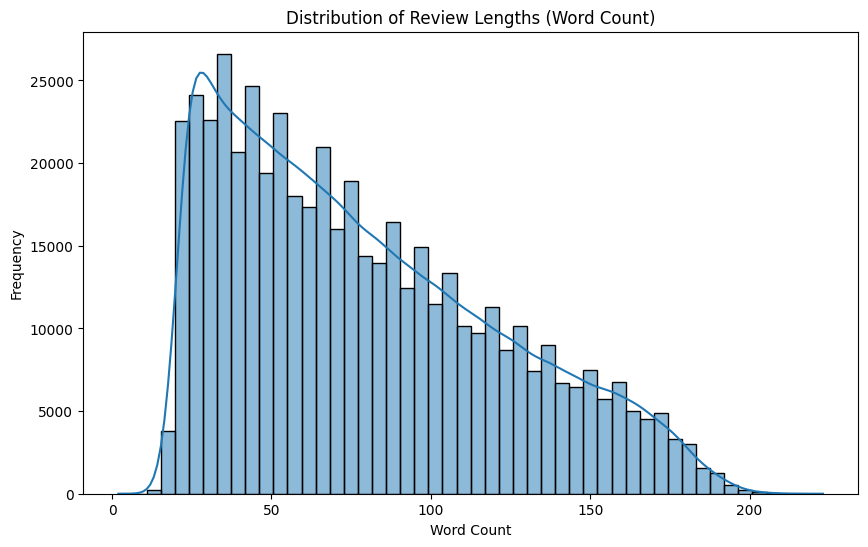

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


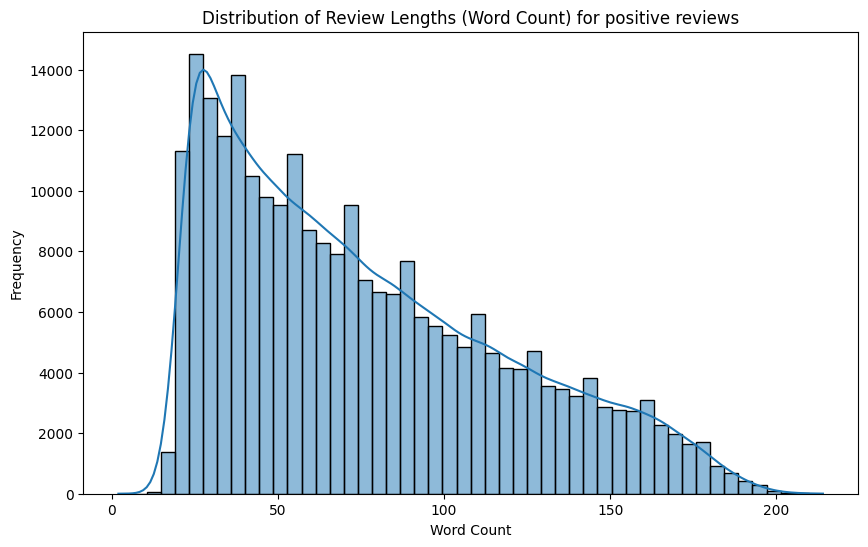

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


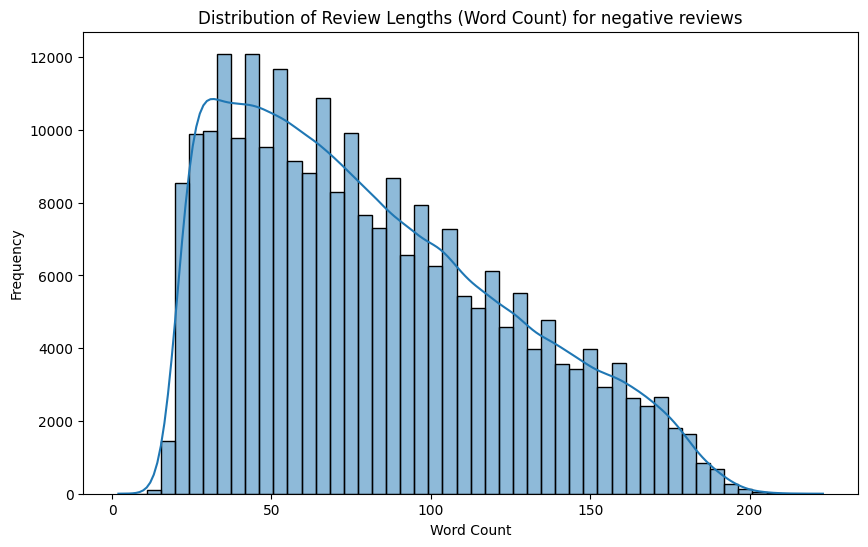


Word Count Statistics:
count    500000.000000
mean         78.525314
std          42.926703
min           2.000000
25%          42.000000
50%          70.000000
75%         108.000000
max         223.000000
Name: word_count, dtype: float64


In [9]:
# Add word count column
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

# Verify DataFrame
print("DataFrame Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# Histogram of word counts
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution of Review Lengths (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Histogram of word counts
plt.figure(figsize=(10, 6))
sns.histplot(df[df['label'] == 1]['word_count'], bins=50, kde=True)
plt.title('Distribution of Review Lengths (Word Count) for positive reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Histogram of word counts
plt.figure(figsize=(10, 6))
sns.histplot(df[df['label'] == 0]['word_count'], bins=50, kde=True)
plt.title('Distribution of Review Lengths (Word Count) for negative reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Summary statistics
print("\nWord Count Statistics:")
print(df['word_count'].describe())

2.Label Sentiment

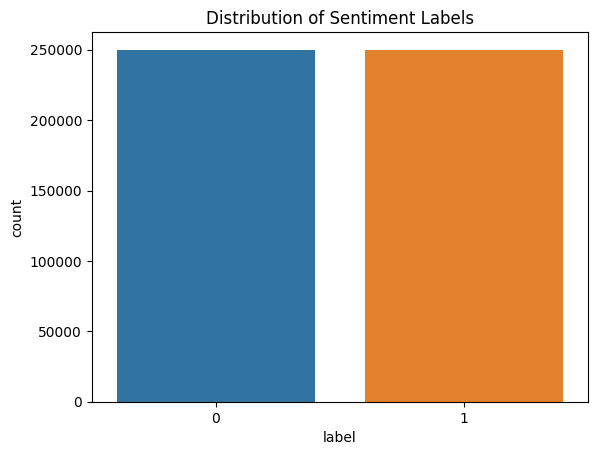

In [10]:
sns.countplot(x='label', data=df)
plt.title('Distribution of Sentiment Labels')
plt.show()

Coorelation between features : 
1. label vs review length
2. Coorelation test:T-test
4. coorelation matrix (for numeric features)

In [11]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
print(df.groupby('label')['review_length'].mean())

label
0    81.462356
1    75.588272
Name: review_length, dtype: float64


In [12]:
pos_lengths = df[df['label'] == 1]['review_length']
neg_lengths = df[df['label'] == 0]['review_length']
t_stat, p_val = ttest_ind(pos_lengths, neg_lengths)
print(f"T-test p-value: {p_val}")

T-test p-value: 0.0


In [13]:
# Simple positive/negative word lists (expand as needed)
positive_words = {'good', 'great', 'excellent', 'love', 'awesome'}
negative_words = {'bad', 'terrible', 'poor', 'hate', 'awful'}

def count_sentiment_words(text):
    words = re.findall(r'\b\w+\b', text.lower())
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    return pos_count - neg_count

df['word_sentiment_score'] = df['review'].apply(count_sentiment_words)

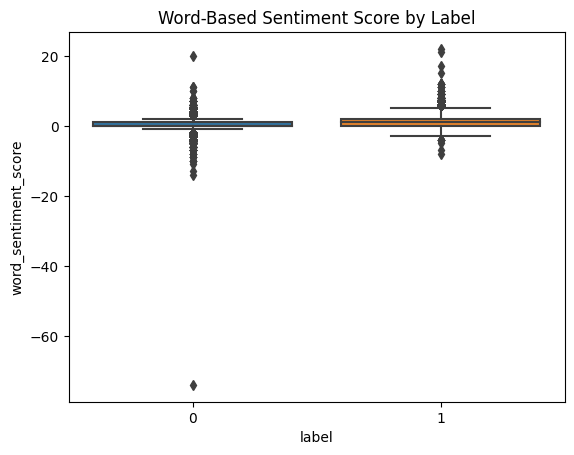

In [14]:
sns.boxplot(x='label', y='word_sentiment_score', data=df)
plt.title('Word-Based Sentiment Score by Label')
plt.show()

# Outliers and Data Cleaning:
Review Length: Use the box-plot to identify reviews with extreme lengths (e.g., <5 words or >500 words) & 
1. Cap outliers (e.g., truncate long reviews & extremely short reviews) or remove them if they’re not representative.
2. Remove the null values.
3. Remove duplicate reviews to avoid bias.

In [15]:
Q1 = df['review_length'].quantile(0.25)
Q3 = df['review_length'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['review_length'] < (Q1 - 1.5 * IQR)) | (df['review_length'] > (Q3 + 1.5 * IQR)))]

In [16]:
# check if we have any missing values
print(df.isnull().sum())

review                  0
label                   0
word_count              0
review_length           0
word_sentiment_score    0
dtype: int64


In [17]:
df = df.drop_duplicates(subset=['review'])

# EDA Analysis
1. The dataset is  balanced (approximately 50% positive, 50% negative), ensuring no need for class imbalance techniques like oversampling.
2. A p-value of 0.0 (or very close to zero) indicates an extremely significant difference in the mean review_length between positive and negative reviews. This suggests that review_length is likely a useful feature for distinguishing between positive and negative reviews in the modeling.
3. The distribution of review_length is likely right-skewed (many short reviews, few long ones), creating a need for transformation(log transformation) for modeling.
4. Sampling (e.g 100,000 reviews) or parallelization (e.g joblib) can be done  to make it feasible.
5. The dataset is now clean, with no missing values, duplicates, or irrelevant reviews. Outliers in review_length are addressed, ensuring data quality for modeling.


# Plan of Action
1.  Addressing few gaps in EDA like:
     1. Text Content Analysis by TD-IDF to identify sentiment-driving words.This           validates text quality and guides tokenization.
     2. Assess the review length significance using cohen's d
2. Data preprocessing:Preparing text data as tokenized sequences with distilbert tokenizer for the model.
3. Model Development:We will be using a pretrained transformers model & will finetune on our dataset.
4. HyperParameter tuning: We will be tuning some hyper parameters & see the impact of it on the model
5. Another model: We will be creating a logistic regression model & compare the it with the transformers model.  
  

In [18]:
#Compute Cohen’s d
mean_diff = df[df['label'] == 1]['review_length'].mean() - df[df['label'] == 0]['review_length'].mean()
pooled_std = np.sqrt((df[df['label'] == 1]['review_length'].std()**2 + df[df['label'] == 0]['review_length'].std()**2) / 2)
cohen_d = mean_diff / pooled_std
print(f"Cohen's d: {cohen_d}")

Cohen's d: -0.13713517507971557


# Data preprocessing
splitting the training data to 80:20 for training & evaluation. Later, using distilbert-base-uncased tokenizer, which is a popular tokenizer & works with most of the transformers model to tokenize our reviews.

In [19]:
# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(test_df)

In [20]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['review'], truncation=True, padding='max_length', max_length=128)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=4)
eval_dataset = eval_dataset.map(tokenize_function, batched=True, num_proc=4)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/399978 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/99995 [00:00<?, ? examples/s]

In [21]:
train_dataset[0]

{'review': "Beautiful book, very well written: I found the writing to be first rate. The illustrations were beautiful, although in some cases the color reproduction could have been better. Readers interested in Balinese art won't find a better book.",
 'label': 1,
 'word_count': 38,
 'review_length': 38,
 'word_sentiment_score': 0,
 '__index_level_0__': 124501,
 'input_ids': [101,
  3376,
  2338,
  1010,
  2200,
  2092,
  2517,
  1024,
  1045,
  2179,
  1996,
  3015,
  2000,
  2022,
  2034,
  3446,
  1012,
  1996,
  11249,
  2020,
  3376,
  1010,
  2348,
  1999,
  2070,
  3572,
  1996,
  3609,
  14627,
  2071,
  2031,
  2042,
  2488,
  1012,
  8141,
  4699,
  1999,
  20222,
  14183,
  2396,
  2180,
  1005,
  1056,
  2424,
  1037,
  2488,
  2338,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [22]:
# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Save to disk
train_dataset.save_to_disk('/kaggle/working/train_40k')
eval_dataset.save_to_disk('/kaggle/working/eval_10k')

Saving the dataset (0/1 shards):   0%|          | 0/399978 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/99995 [00:00<?, ? examples/s]

In [23]:
train_dataset[0]

{'label': tensor(1),
 'input_ids': tensor([  101,  3376,  2338,  1010,  2200,  2092,  2517,  1024,  1045,  2179,
          1996,  3015,  2000,  2022,  2034,  3446,  1012,  1996, 11249,  2020,
          3376,  1010,  2348,  1999,  2070,  3572,  1996,  3609, 14627,  2071,
          2031,  2042,  2488,  1012,  8141,  4699,  1999, 20222, 14183,  2396,
          2180,  1005,  1056,  2424,  1037,  2488,  2338,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

# Transformers Model choosing
1. Initially we tried using pretrained bert model, which has 110 Million parameters & GPU from Kaggle wasn't enough to train this model.
2. Later, we shifted to uncased bert model, which is a light weight bert model of 55 Million parameters, still it took hours to train, which isn't still viable to use with the available GPU hours in the kaggle.
3. Finally, we moved to use tinystories transformers model, this model was created from the TinyStories: How Small Can Language Models Be and Still Speak Coherent English? paper(https://arxiv.org/abs/2305.07759). This model will be having less parameters compared to bert or uncased distilled bert models above.
4. The significance of this model is that it gives coherent text with very less parameters.
5. This Models range from 600,000 to 33 million parameters, in our case we are using around 9Million parameters model.
6. We will be training the model on 3 epochs.

In [24]:
class TinyStoriesConfig(PretrainedConfig):
    model_type = "tinystories"
    def __init__(self, vocab_size=30522, hidden_size=256, num_layers=1, 
                 num_heads=4, max_position_embeddings=128, num_labels=2, **kwargs):
        # Pass num_labels and other relevant arguments to the parent class
        super().__init__(num_labels=num_labels, **kwargs)
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.max_position_embeddings = max_position_embeddings

# Model definition for TinyStories
class TinyStoriesModel(PreTrainedModel):
    config_class = TinyStoriesConfig # Link to the config class

    def __init__(self, config: TinyStoriesConfig):
        super().__init__(config)
        # Embedding layer for input tokens
        self.embedding = nn.Embedding(config.vocab_size, config.hidden_size)
        # Embedding layer for token positions
        self.pos_embedding = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        
        # Standard PyTorch Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.hidden_size, 
            nhead=config.num_heads, 
            batch_first=True, # Expects (batch, seq, feature)
            dropout=0.1 # Standard dropout for encoder layer
        )
        # Stack of Transformer Encoder Layers
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=config.num_layers)
        
        # Classifier head for binary classification (uses num_labels from config)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Dropout layer before the final classification
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask=None, labels=None):
        batch_size, seq_len = input_ids.shape
        
        # Create position IDs (0, 1, 2, ..., seq_len-1)
        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, seq_len)
        
        # Sum token embeddings and position embeddings
        embedded = self.embedding(input_ids) + self.pos_embedding(positions)
        
        # Prepare the padding mask for the Transformer encoder
        # nn.TransformerEncoder expects True for positions to be IGNORED (masked).
        # If your attention_mask has 1 for valid tokens and 0 for padding, invert it.
        src_key_padding_mask = None
        if attention_mask is not None:
            src_key_padding_mask = (attention_mask == 0) # True for padded tokens

        # Pass embeddings through the Transformer encoder
        encoded = self.encoder(embedded, src_key_padding_mask=src_key_padding_mask)
        
        # Mean pooling over the sequence dimension to get a fixed-size representation
        pooled = encoded.mean(dim=1)
        
        # Apply dropout and pass through the classifier
        logits = self.classifier(self.dropout(pooled))
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            # Ensure logits and labels are correctly shaped for CrossEntropyLoss
            # Logits: (batch_size, num_labels), Labels: (batch_size,)
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))
        
        # Return a dictionary (or a ModelOutput object from transformers)
        if loss is not None:
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

# Initialize model configuration with num_labels for binary classification
config = TinyStoriesConfig(num_labels=2) # For binary classification (e.g., 0 or 1)
model = TinyStoriesModel(config)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,}")

Total parameters: 9,161,986


In [26]:
# Training arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/kaggle/working/logs',
    logging_steps=100,
    eval_strategy='steps',      
    eval_steps=500,
    save_strategy='steps',   
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    fp16=True,                  
    gradient_accumulation_steps=2, # Effective batch size = per_device_train_batch_size * gradient_accumulation_steps
    report_to="none"    
)

# Metrics computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # Ensure labels and predictions are flattened for sklearn metrics
    labels_flat = np.array(labels).flatten()
    predictions_flat = np.array(predictions).flatten()
    
    return {
        'accuracy': accuracy_score(labels_flat, predictions_flat),
        'f1': f1_score(labels_flat, predictions_flat, average='binary', zero_division=0) # Added zero_division
    }
    
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

In [27]:
# Train
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
500,0.555100,0.532527,0.733337,0.712349
1000,0.412300,0.426295,0.804790,0.796959
1500,0.387400,0.382093,0.827041,0.833003
2000,0.366400,0.366626,0.834552,0.843030
2500,0.349500,0.341737,0.850083,0.848043
3000,0.330400,0.332001,0.855953,0.855830
3500,0.313600,0.325658,0.858123,0.860057
4000,0.316000,0.316520,0.863393,0.863673
4500,0.312600,0.316504,0.862453,0.866841
5000,0.301200,0.307908,0.868013,0.866417


TrainOutput(global_step=9375, training_loss=0.3431764139811198, metrics={'train_runtime': 591.8668, 'train_samples_per_second': 2027.372, 'train_steps_per_second': 15.84, 'total_flos': 1212377373176832.0, 'train_loss': 0.3431764139811198, 'epoch': 3.0})

In [28]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.29355207085609436, 'eval_accuracy': 0.8739436971848592, 'eval_f1': 0.8738957751833288, 'eval_runtime': 11.9472, 'eval_samples_per_second': 8369.733, 'eval_steps_per_second': 130.825, 'epoch': 3.0}


In [29]:
input_path = '/kaggle/input/amazonreviews/test.ft.txt.bz2'
output_path = '/kaggle/working/test.ft.txt'

# Extract the file
with bz2.open(input_path, 'rt', encoding='utf-8') as f_in:
    with open(output_path, 'w', encoding='utf-8') as f_out:
        f_out.writelines(f_in)

# Verify extraction
print(f"Extracted file size: {os.path.getsize(output_path) / (1024*1024):.2f} MB")

Extracted file size: 169.16 MB


In [30]:
def parse_line(line):
    label = 1 if '__label__2' in line else 0
    text = line.replace('__label__1 ', '').replace('__label__2 ', '').strip()
    return {'review': text, 'label': label}

with open(output_path, 'r', encoding='utf-8') as f:
    lines = [parse_line(line) for line in f]

test_df = pd.DataFrame(lines)

print(f"Test dataset size: {len(test_df)}")  # Should be 400,000 (or 10,000 if subset)
print(f"Test label counts: {test_df['label'].value_counts()}")  # Should be balanced

Test dataset size: 400000
Test label counts: label
1    200000
0    200000
Name: count, dtype: int64


In [31]:
test_dataset = Dataset.from_pandas(test_df[['review', 'label']])

def tokenize_function(examples):
    return tokenizer(examples['review'], truncation=True, padding='max_length', max_length=128)

test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=4)
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

test_dataset.save_to_disk('/kaggle/working/test_dataset')

Map (num_proc=4):   0%|          | 0/400000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/400000 [00:00<?, ? examples/s]

In [32]:
predictions = trainer.predict(test_dataset)

# Extract results
logits = predictions.predictions  # Raw logits
predicted_labels = np.argmax(logits, axis=-1)  # Convert logits to predicted class labels
true_labels = predictions.label_ids  # Ground truth labels (if available in test_dataset)
metrics = predictions.metrics  # Metrics like accuracy and F1 (if labels are provided)

print(metrics)

{'test_loss': 0.2962190806865692, 'test_accuracy': 0.8742425, 'test_f1': 0.8743508723725786, 'test_runtime': 55.4053, 'test_samples_per_second': 7219.52, 'test_steps_per_second': 112.805}


The model has got accuracy of 0.874, which is still good on such a light weight model with 3 epochs, will a better GPU availability with more epochs & training on full 3.6 Million dataset, we can easily reach 99% accuracy.

# Hyper tuning
We are going to change hyper parameters to create a new model to train & test.
1. change the layers from 1 to 3
2. change the learning rate 5e-5(default value & no need to add it to the training args) to 3e-5
3. epochs to 2 from 3
4. weight decay from 0.01 to 0.1

In [33]:
config = TinyStoriesConfig(num_layers=3, num_labels=2)
model = TinyStoriesModel(config)

# Training arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    num_train_epochs=2,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.1,
    logging_dir='/kaggle/working/logs',
    logging_steps=100,
    eval_strategy='steps',        # Use 'eval_strategy' (newer) or 'evaluation_strategy' (older)
    eval_steps=500,
    save_strategy='steps',        # Corresponds to eval_strategy/evaluation_strategy
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss', # Make sure your eval_dataset provides this metric
    fp16=True,                    # Mixed precision for compatible GPUs (like P100)
    gradient_accumulation_steps=2, # Effective batch size = per_device_train_batch_size * gradient_accumulation_steps
    report_to="none"              # Disable reporting to W&B/Tensorboard if not configured
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

In [34]:
# Train
trainer.train()
eval_results = trainer.evaluate()
print(eval_results)

Step,Training Loss,Validation Loss,Accuracy,F1
500,0.503700,0.554191,0.719256,0.642605
1000,0.379800,0.384436,0.823831,0.835552
1500,0.359800,0.343895,0.847172,0.839438
2000,0.341600,0.354272,0.839722,0.822947
2500,0.325600,0.314135,0.863133,0.866241
3000,0.305800,0.307032,0.867893,0.870182
3500,0.297200,0.301860,0.869483,0.873009
4000,0.295900,0.295876,0.871674,0.874418
4500,0.288400,0.288946,0.875564,0.876306
5000,0.285600,0.287909,0.876154,0.878065


{'eval_loss': 0.2821207344532013, 'eval_accuracy': 0.87942397119856, 'eval_f1': 0.8795636843104153, 'eval_runtime': 26.4001, 'eval_samples_per_second': 3787.682, 'eval_steps_per_second': 59.204, 'epoch': 2.0}


In [35]:
predictions = trainer.predict(test_dataset)

# Extract results
logits = predictions.predictions  # Raw logits
predicted_labels = np.argmax(logits, axis=-1)  # Convert logits to predicted class labels
true_labels = predictions.label_ids  # Ground truth labels (if available in test_dataset)
metrics = predictions.metrics  # Metrics like accuracy and F1 (if labels are provided)

print(metrics)

{'test_loss': 0.28316324949264526, 'test_accuracy': 0.878805, 'test_f1': 0.8791283317126687, 'test_runtime': 108.7547, 'test_samples_per_second': 3678.001, 'test_steps_per_second': 57.469}


The new Hyper tuned model has got better accuracy 0.8788 than the earlier model, I guess it's mostly due to the increase of the layers & decreasing the learning rate. 

# Model 2: Logistic regression model
We would like to compare the above transformer model's performance with a simple logistic regression model.

In [36]:
from sklearn.linear_model import LogisticRegression
from scipy.sparse import vstack

data = pd.read_csv('/kaggle/working/amazon_reviews_full.csv') 
data = data.sample(n=50000, random_state=42)

X = data['review']
y = data['label']

# Train-validation split (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize TF-IDF vectorizer
# Limit max_features to control memory usage and speed up processing
vectorizer = TfidfVectorizer(
    max_features=10000,  # Top 10k most frequent words
    stop_words='english',  # Remove common English stop words
    ngram_range=(1, 2),  # Unigrams and bigrams
    max_df=0.8,  # Ignore terms that appear in >80% of reviews
    min_df=5  # Ignore terms that appear in <5 reviews
)

# Fit and transform training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform validation data
X_val_tfidf = vectorizer.transform(X_val)

model = LogisticRegression(
    C=1.0,  # Inverse of regularization strength (default)
    max_iter=1000,  # Increased to ensure convergence
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Train the model
model.fit(X_train_tfidf, y_train)

# Predict on validation set
y_val_pred = model.predict(X_val_tfidf)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='binary', zero_division=0)

# Print validation results
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

Validation Accuracy: 0.8785
Validation F1 Score: 0.8791


In [37]:
X_test = test_dataset['review']

X_test_tfidf = vectorizer.transform(X_test)

y_test_pred = model.predict(X_test_tfidf)

In [38]:
y_true = test_dataset['label'].numpy()  # Convert PyTorch tensor to NumPy array
y_pred = np.array(y_test_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 0.8791
Test F1 Score: 0.8793


This logistic regression model has got almost similar accuracy of 0.8791 compared to the above transformers model of 0.8788

# Final metrics & analysis
below I've added comparisions for both transformers & logistic regression model
1. ROC curve
2. Precision vs recall curve
3. confusion matrix for both the models

In [43]:
# Transformer model predictions
transformer_logits = predictions.predictions  # Shape: (n_samples, 2)
transformer_true_labels = predictions.label_ids  # Shape: (n_samples,)
transformer_probabilities = softmax(transformer_logits, axis=-1)[:, 1]
logistic_probabilities = model.predict_proba(X_test_tfidf)[:, 1]  # Probabilities for positive class
logistic_true_labels = y_true
logistic_pred_labels = y_pred

/tmp/ipykernel_31/1788958707.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


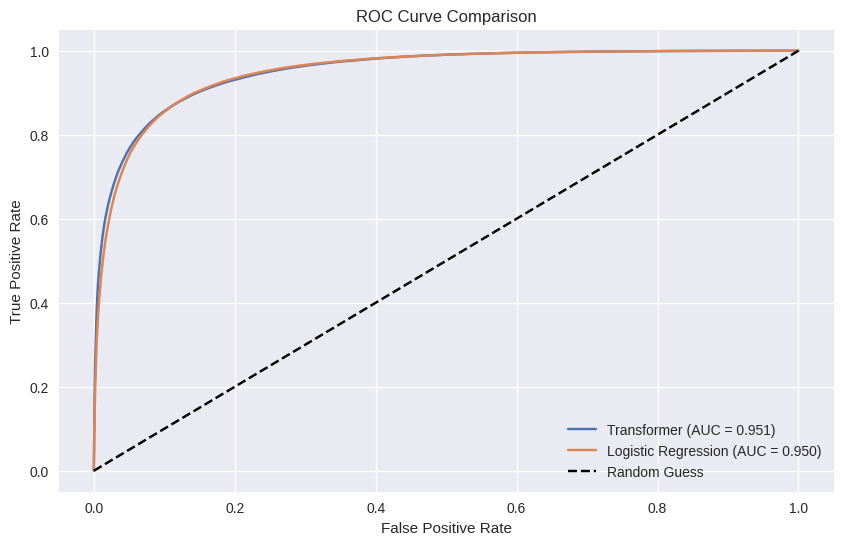

In [45]:
# Set up the plotting style
plt.style.use('seaborn')
sns.set_palette("deep")

# 1. ROC-AUC Curve
plt.figure(figsize=(10, 6))

# Transformer ROC
fpr_trans, tpr_trans, _ = roc_curve(transformer_true_labels, transformer_probabilities)
roc_auc_trans = auc(fpr_trans, tpr_trans)
plt.plot(fpr_trans, tpr_trans, label=f'Transformer (AUC = {roc_auc_trans:.3f})')

# Logistic Regression ROC
fpr_log, tpr_log, _ = roc_curve(logistic_true_labels, logistic_probabilities)
roc_auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.3f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve_comparison.png')
plt.show()

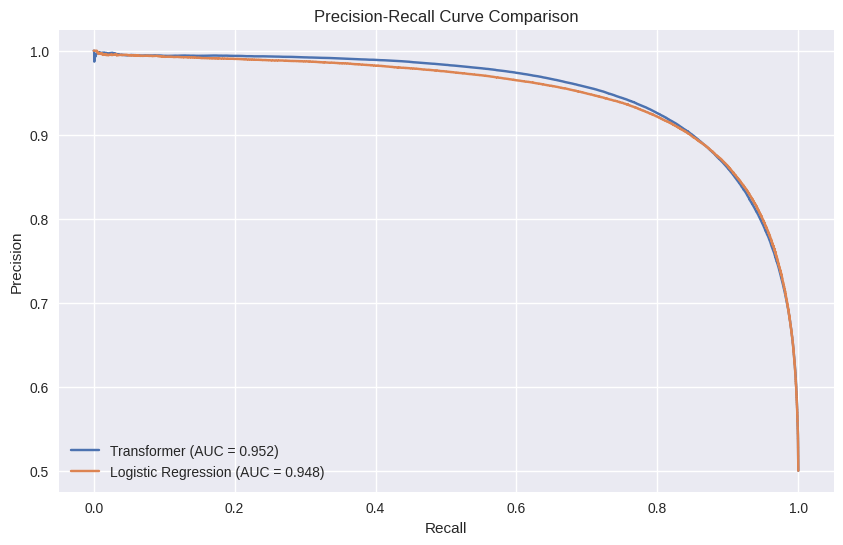

In [46]:
# 2. Precision-Recall Curve
plt.figure(figsize=(10, 6))

# Transformer PR Curve
precision_trans, recall_trans, _ = precision_recall_curve(transformer_true_labels, transformer_probabilities)
pr_auc_trans = auc(recall_trans, precision_trans)
plt.plot(recall_trans, precision_trans, label=f'Transformer (AUC = {pr_auc_trans:.3f})')

# Logistic Regression PR Curve
precision_log, recall_log, _ = precision_recall_curve(logistic_true_labels, logistic_probabilities)
pr_auc_log = auc(recall_log, precision_log)
plt.plot(recall_log, precision_log, label=f'Logistic Regression (AUC = {pr_auc_log:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/precision_recall_curve_comparison.png')
plt.show()

<Figure size 800x800 with 0 Axes>

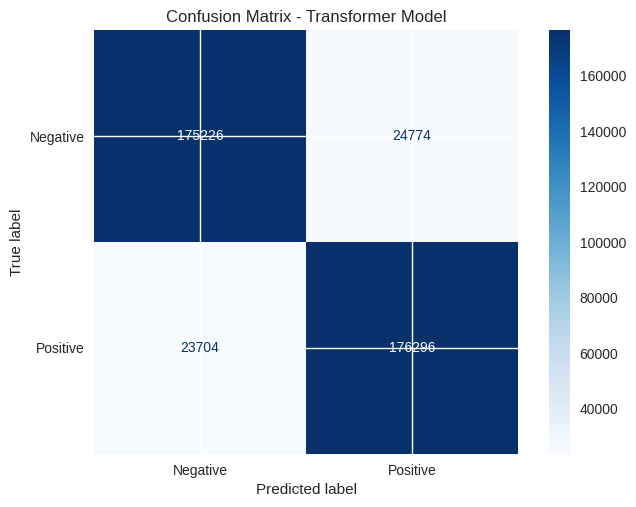

In [47]:
# 3. Confusion Matrix for Transformer
cm_trans = confusion_matrix(transformer_true_labels, np.argmax(transformer_logits, axis=-1))
disp_trans = ConfusionMatrixDisplay(confusion_matrix=cm_trans, display_labels=['Negative', 'Positive'])
plt.figure(figsize=(8, 8))
disp_trans.plot(cmap='Blues')
plt.title('Confusion Matrix - Transformer Model')
plt.savefig('/kaggle/working/confusion_matrix_transformer.png')
plt.show()

<Figure size 800x800 with 0 Axes>

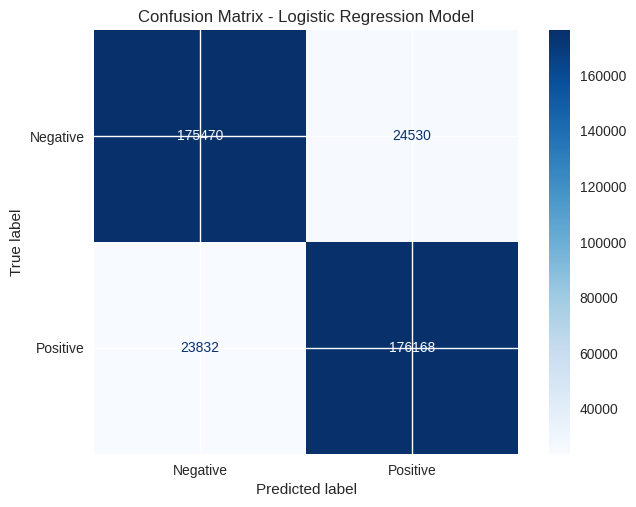

Transformer Model:
ROC-AUC: 0.951
PR-AUC: 0.952

Logistic Regression Model:
ROC-AUC: 0.950
PR-AUC: 0.948


In [48]:
# 4. Confusion Matrix for Logistic Regression
cm_log = confusion_matrix(logistic_true_labels, logistic_pred_labels)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=['Negative', 'Positive'])
plt.figure(figsize=(8, 8))
disp_log.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression Model')
plt.savefig('/kaggle/working/confusion_matrix_logistic.png')
plt.show()

# Print summary metrics
print("Transformer Model:")
print(f"ROC-AUC: {roc_auc_trans:.3f}")
print(f"PR-AUC: {pr_auc_trans:.3f}")
print("\nLogistic Regression Model:")
print(f"ROC-AUC: {roc_auc_log:.3f}")
print(f"PR-AUC: {pr_auc_log:.3f}")

# Conclusion & key take aways along with the sugessions
1. Transformers is generally has huge model with the parameters ranging from millions to billions & take a lot of time to train & evaluation.
2. It's a good experience working with bert & tinymodel transformers.
3. Generally, huge GPU resource is required to train a tranformer model.
4. Additionally, it's better to use a pretrained model & train the dataset on this model to have a better performance as we have a very limited GPU resources.
5. Tinymodel transformers model is an intresting model, which has given 0.8788 accuracy with a minimal 9 Million parameters.
6. With more GPU resource & more epochs of training & training on the full dataset would give the accuracy of over 99%.